# EDA example - Marketing analytics

<div>
<img src="images/marketing.PNG" width="400"/>
</div>


1. [Wrangling data](#section1)

   1.1 [Fix columns](#section1.1)   
   1.2 [Missing values](#section1.2)  
   1.3 [Outliers](#section1.3)    
   1.4 [Transformations](section1.4)
  
2. [Understand the data](#section2)
3. [Correlations](#section3)
4. [Categorical data](#section4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We'll work with a small marketing analytics dataset, taken from [iFood](https://www.crunchbase.com/organization/ifood)

Based on the example [here](https://www.kaggle.com/jennifercrockett/marketing-analytics-eda-task-final)

In [2]:
url = 'https://raw.githubusercontent.com/nlihin/data-analytics/main/datasets/marketing_data.csv'
mrkt_df = pd.read_csv(url)
mrkt_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


Data description in an image, and also [here](https://www.kaggle.com/jackdaoud/marketing-data)

<div>
<img src="images/ifood.png" width="700"/>
</div>



<a id='section1'></a>

---
### 1. Wrangling data



<a id='section1.1'></a>

#### 1.1 Fix columns

You may already notice something is strange with the Income column, is it aligned to the right??

Let's look at the types of data

In [3]:
mrkt_df.dtypes

ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object

So here is the problem: the 'Income' column contains extra whitespace, clean it:

In [4]:
mrkt_df.columns = mrkt_df.columns.str.replace(' ', '')

And: the 'Income' column should be turned to numeric (float is better)

In [5]:
# transform Income column to a numerical
mrkt_df['Income'] = mrkt_df['Income'].str.replace('$', '')
mrkt_df['Income'] = mrkt_df['Income'].str.replace(',', '').astype('float')

Check that our changes worked:

In [6]:
mrkt_df.dtypes['Income']

dtype('float64')

Change the date column to a date type

In [7]:
mrkt_df['Dt_Customer'] = pd.to_datetime(mrkt_df['Dt_Customer'])

<a id='section1.2'></a>

#### 1.2 Missing values

In [8]:
mrkt_df.isnull().sum().sort_values(ascending=False)

Income                 24
Country                 0
Complain                0
Year_Birth              0
Education               0
Marital_Status          0
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
ID                      0
dtype: int64

The feature Income contains 24 null values

Plot this feature to identify best strategy for imputation



array([[<AxesSubplot:title={'center':'Income'}>]], dtype=object)

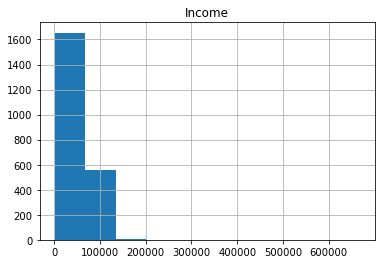

In [9]:
mrkt_df.hist('Income')

Try more bins to get a better idea:

array([[<AxesSubplot:title={'center':'Income'}>]], dtype=object)

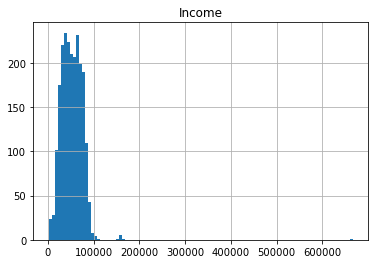

In [10]:
mrkt_df.hist('Income',bins=100)

<AxesSubplot:>

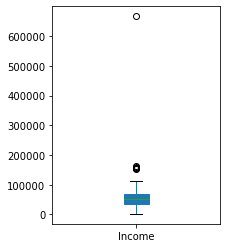

In [11]:
mrkt_df['Income'].plot(kind='box', figsize=(3,4), patch_artist=True)

Findings:

Most incomes are distributed between $0-\$100,000, with a few outliers

Replace null values with median value, to avoid effects of outliers on imputation value

In [12]:
mrkt_df['Income'] = mrkt_df['Income'].fillna(mrkt_df['Income'].median())

<a id='section1.3'></a>

#### 1.3 Noisy data - outliers

Plot only numeric columns, that are not binary or an ID:

In [13]:
#remove binary and ID
df_to_plot = mrkt_df.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain'])

#select only numeric columns
df_to_plot = df_to_plot.select_dtypes(include=np.number)


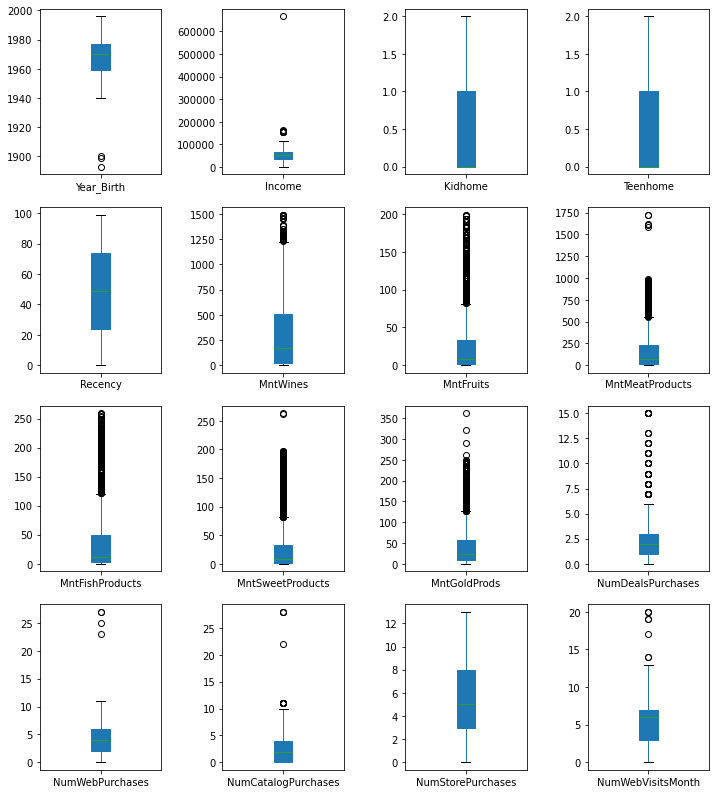

In [14]:
# subplots
df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

Findings: 

Multiple features contain outliers (see boxplots), but the only that likely indicate data entry errors are Year_Birth <= 1900

How many are there?

In [15]:
mrkt_df[mrkt_df['Year_Birth'] < 1900]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
513,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,...,2,4,0,0,0,0,0,0,0,SA
827,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,...,4,1,0,0,1,0,0,0,0,SP


Remove people born before 1900: 

In [16]:
mrkt_df = mrkt_df[mrkt_df['Year_Birth'] > 1900].reset_index(drop=True)

Check (patch_artist fills the boxplot with color)

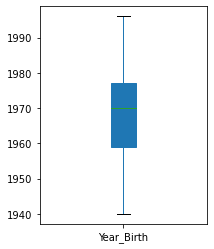

In [17]:
plt.figure(figsize=(3,4))
mrkt_df['Year_Birth'].plot(kind='box', patch_artist=True);

You can also plot via pandas:

<AxesSubplot:>

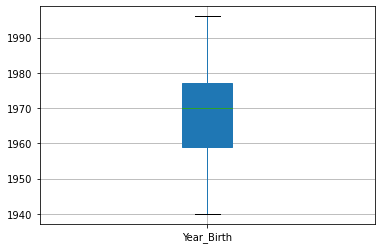

In [18]:
mrkt_df.boxplot('Year_Birth', patch_artist=True)

<a id='section1.1'></a>

#### 1.4 Transformations

In [19]:
mrkt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2237 non-null   int64         
 1   Year_Birth           2237 non-null   int64         
 2   Education            2237 non-null   object        
 3   Marital_Status       2237 non-null   object        
 4   Income               2237 non-null   float64       
 5   Kidhome              2237 non-null   int64         
 6   Teenhome             2237 non-null   int64         
 7   Dt_Customer          2237 non-null   datetime64[ns]
 8   Recency              2237 non-null   int64         
 9   MntWines             2237 non-null   int64         
 10  MntFruits            2237 non-null   int64         
 11  MntMeatProducts      2237 non-null   int64         
 12  MntFishProducts      2237 non-null   int64         
 13  MntSweetProducts     2237 non-nul

Transform the date to a datetime object:

In [20]:
mrkt_df['Dt_Customer'] = pd.to_datetime(mrkt_df['Dt_Customer'])

<a id='section2'></a>

### 2. Understand the data

The total number of dependents in the home ('Dependents') can be engineered from the sum of 'Kidhome' and 'Teenhome'

In [21]:
mrkt_df['Dependents'] = mrkt_df['Kidhome'] + mrkt_df['Teenhome']

The year of becoming a customer ('Year_Customer') can be engineered from 'Dt_Customer'

In [22]:
mrkt_df['Year_Customer'] = pd.DatetimeIndex(mrkt_df['Dt_Customer']).year

The total amount spent ('TotalMnt') can be engineered from the sum of all features containing the keyword 'Mnt'

---

We will use [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) to do that 

A list comprehension consists of brackets containing an expression followed by a for clause, then zero or more for or if clauses. 

In [23]:
squares = []
for x in range(10):
    squares.append(x**2)
    squares
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [24]:
squares = [x**2 for x in range(10)]
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

---

In [25]:
mnt_cols = [col for col in mrkt_df.columns if 'Mnt' in col]
mnt_cols

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

We have used `.sum()` to sum by columns. Now we want to sum rows. So `axis=1`

In [26]:
mrkt_df['TotalMnt'] = mrkt_df[mnt_cols].sum(axis=1)

The total purchases ('TotalPurchases') can be engineered from the sum of all features containing the keyword 'Purchases'

In [27]:
purchases_cols = [col for col in mrkt_df.columns if 'Purchases' in col]
mrkt_df['TotalPurchases'] = mrkt_df[purchases_cols].sum(axis=1)

The total number of campains accepted ('TotalCampaignsAcc') can be engineered from the sum of all features containing the keywords 'Cmp' and 'Response' (the latest campaign)

In [28]:
campaigns_cols = [col for col in mrkt_df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
mrkt_df['TotalCampaignsAcc'] = mrkt_df[campaigns_cols].sum(axis=1)

Look at our new columns

In [29]:
mrkt_df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc', 'NumDealsPurchases']].head(10)

,ID,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc,NumDealsPurchases
0,1826,0,2014,1190,15,1,1
1,1,0,2014,577,18,2,1
2,10476,1,2014,251,11,0,1
3,1386,2,2014,11,4,0,1
4,5371,1,2014,91,8,2,2
5,7348,0,2014,1192,17,1,1
6,4073,0,2014,1215,28,2,1
7,1991,1,2014,96,7,0,1
8,4047,1,2014,544,20,0,3
9,9477,1,2014,544,20,0,3


<a id='section3'></a>

### 3. Correlations - patterns in the data

To find patterns in the data, we need to find correlations in the data

To understand what type of correlation, plot the histograms

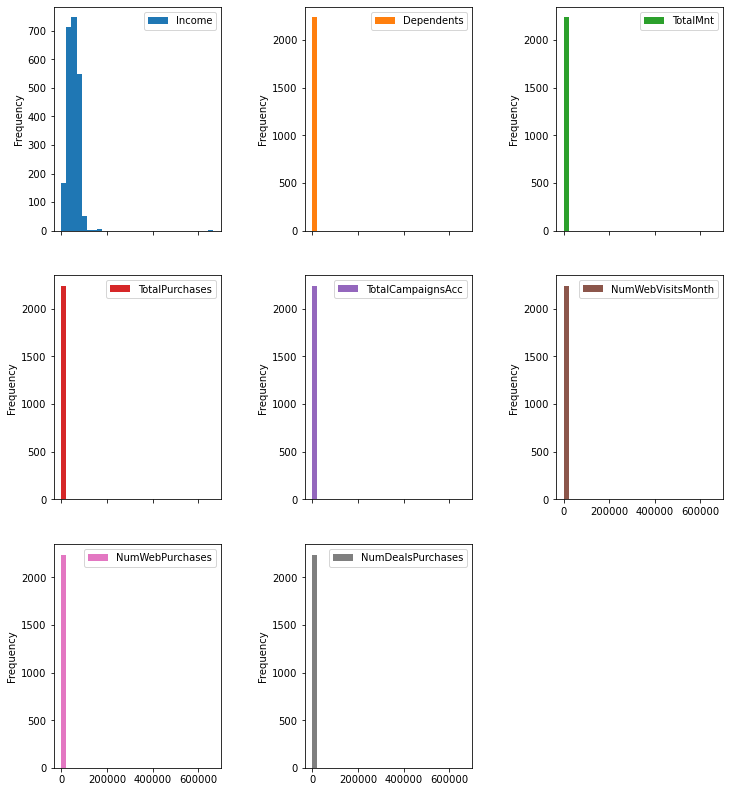

In [30]:
features = ['Income', 'Dependents','TotalMnt','TotalPurchases', 'TotalCampaignsAcc', 'NumWebVisitsMonth', 'NumWebPurchases', 'NumDealsPurchases']
mrkt_df[features].plot(subplots=True, layout=(3,3), kind='hist', figsize=(12,14), bins = 30)
plt.subplots_adjust(wspace=0.5);

wait.. is this correct? I suspect the x-axis scale is wrong. Let's try plotting only one feature:

<AxesSubplot:>

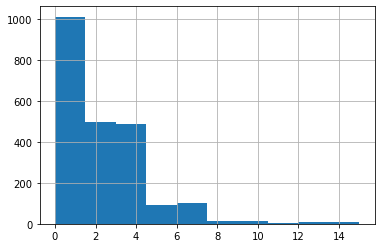

In [31]:
mrkt_df['NumDealsPurchases'].hist()

suscpicion confirmed. Let's try again:

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>]], dtype=object)

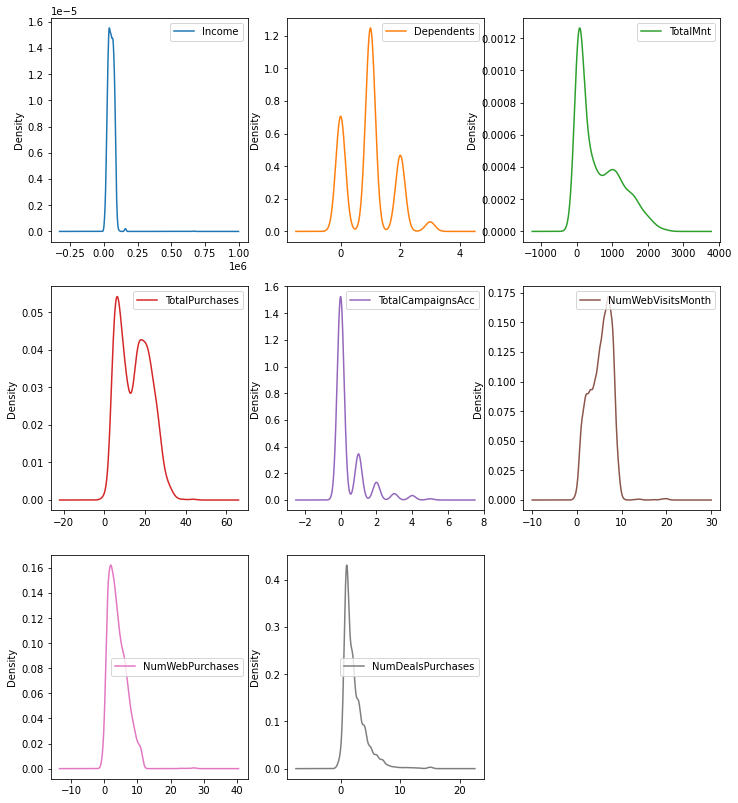

In [32]:
mrkt_df[features].plot.density(subplots=True, sharex=False, sharey=False, layout=(3, 3), figsize=(12,14))

This is not even close to a normal distribution, so use kendall-tau

Use all numeric columns except the 'ID' column

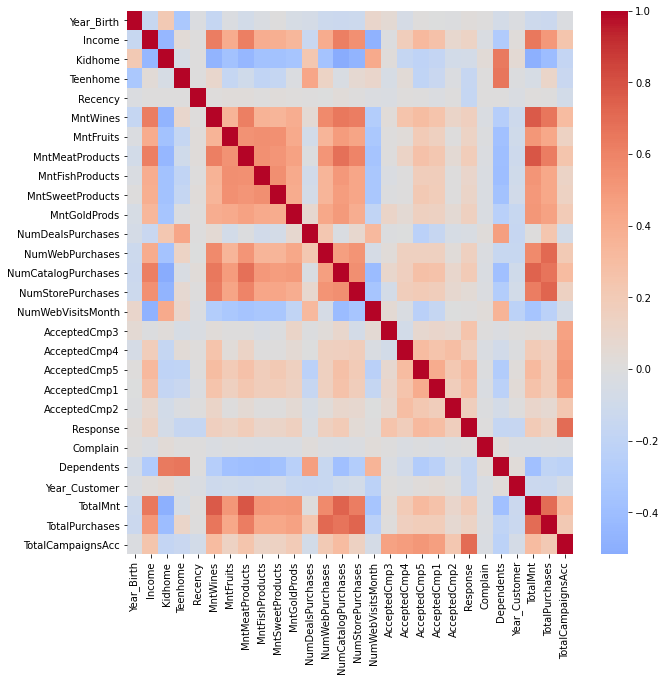

In [33]:
corrs = mrkt_df.drop(columns='ID').corr(method = 'kendall')

plt.figure(figsize=(10,10))  #figure size
sns.heatmap(corrs,  cmap='coolwarm', center =0 );  #centeral color of the colormap (cmap)

Try again, less features:

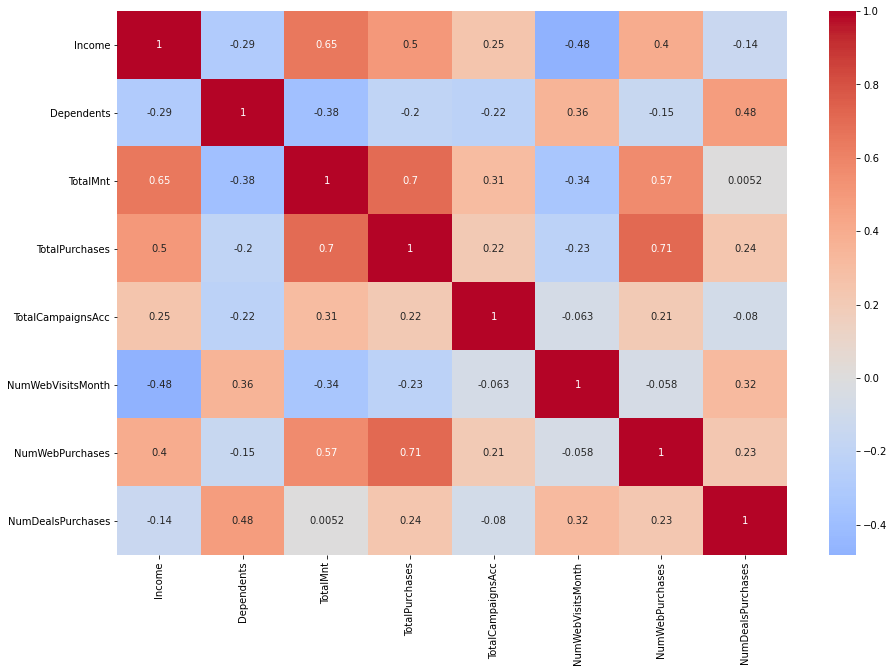

In [34]:
corrs = mrkt_df[features].corr(method = 'kendall')

plt.figure(figsize=(15,10))  #figure size
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True);

We found some correlations :-)

Let's begin with income and spendings

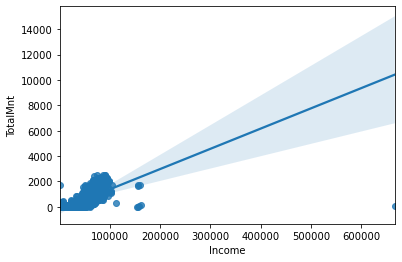

In [35]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df);

the same, but remove the outliers:

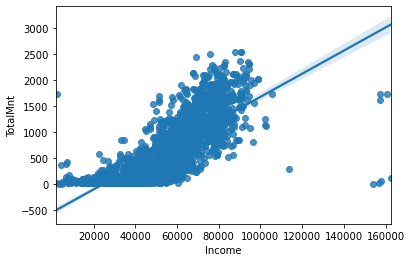

In [36]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df[mrkt_df['Income'] < 200000]);

---

>##### Observation 1:
>
>The higher the income is, the more you spend
>
> (a bit trivial)
---

Plot illustrating negative effect of having dependents (kids & teens) on spending:
    
A linear plot doesn't look good here since data is discrete (same for ordinal data - e.g. - none, few, many)

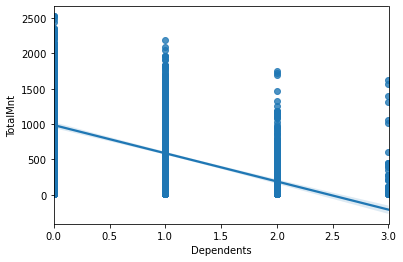

In [37]:
sns.regplot(x='Dependents', y='TotalMnt', data=mrkt_df);

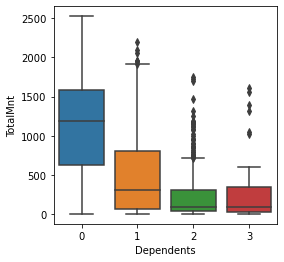

In [38]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='TotalMnt', data=mrkt_df);

Plot illustrating positive effect of having dependents (kids & teens) on number of deals purchased:

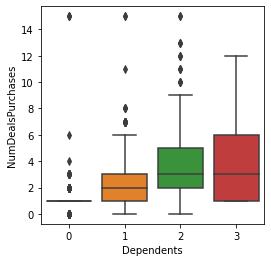

In [39]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='NumDealsPurchases', data=mrkt_df);

---

>##### Observation 2:
>
>People with more kids spend less
>
>People with more kids buy more deals


---

Plots illustrating the positive effect of campaigns

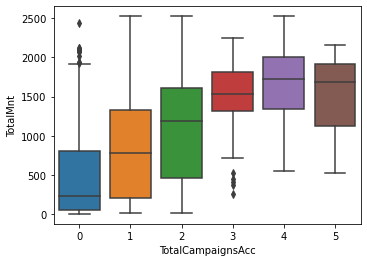

In [40]:
plt.figure(figsize=(5.5,4))
sns.boxplot(x='TotalCampaignsAcc', y='TotalMnt', data=mrkt_df);

---

>##### Observation 3:
>
>Campaigns seem to be working

---

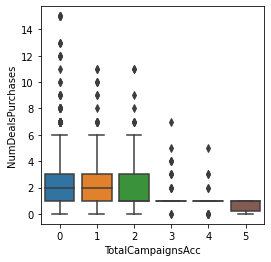

In [41]:
plt.figure(figsize=(4,4))
sns.boxplot(x='TotalCampaignsAcc', y='NumDealsPurchases', data=mrkt_df);

---

>##### Observation??
>
> Campigns don't seem to corrolate with deals (this may be a good thing)
>
---

What about web visits and web purchases?

<AxesSubplot:xlabel='NumWebVisitsMonth', ylabel='NumWebPurchases'>

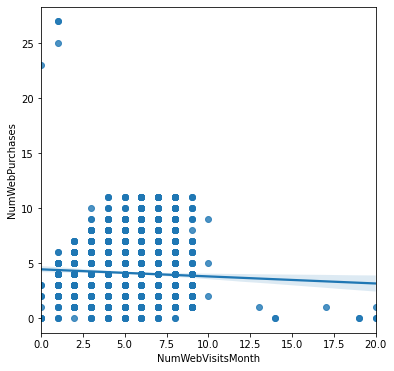

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(x='NumWebVisitsMonth', y='NumWebPurchases', data=mrkt_df)

<AxesSubplot:xlabel='NumWebVisitsMonth', ylabel='NumDealsPurchases'>

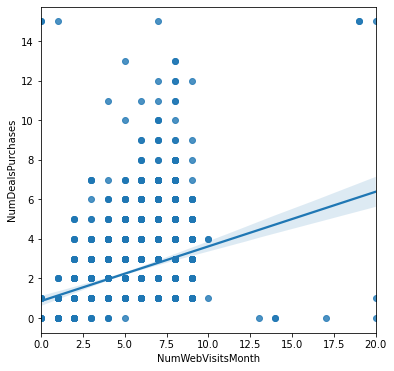

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x='NumWebVisitsMonth', y='NumDealsPurchases', data=mrkt_df)

---

>##### Observation 4:
>
> Number of web visits in the last month is not positively correlated with number of web purchases
>
> Instead, it is positively correlated with the number of deals purchased, suggesting that deals are an effective way of stimulating purchases on the website

---

<a id='section4'></a>

### 4. Categorical data

<div>
<img src="images/categories.jpeg" width="400"/>
</div>


We have some categorical data.

Plot it in one row, or on seperate rows. Here's one row:

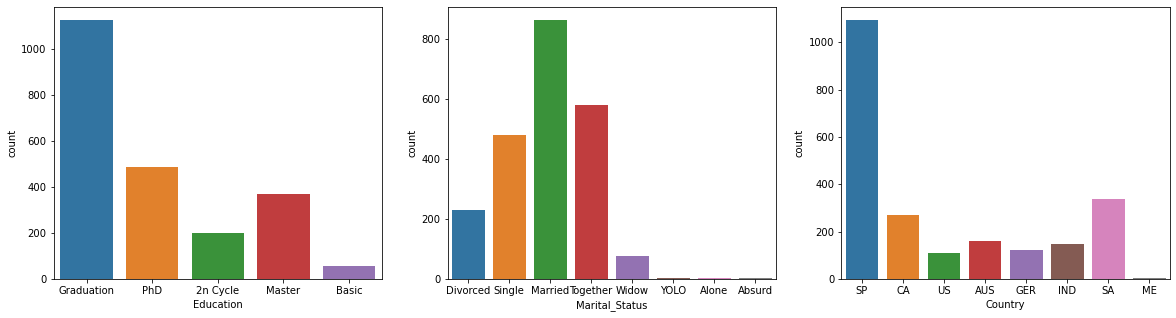

In [44]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=3)
sns.countplot(ax=axes[0], x="Education", data=mrkt_df)
sns.countplot(ax=axes[1], x="Marital_Status", data=mrkt_df)
sns.countplot(ax=axes[2], x="Country", data=mrkt_df)
plt.show()


Let's look at the marital status:

In [45]:
mrkt_df.groupby('Marital_Status')[['ID']].count()

,ID
Marital_Status,
Absurd,2
Alone,3
Divorced,231
Married,864
Single,479
Together,579
Widow,77
YOLO,2


##### Is there a correlation between marital status and spendings?

Create a df that holds only the status's we're interested in - the four biggest categories

In [46]:
status_mrkt = mrkt_df.loc[(mrkt_df.Marital_Status  == 'Single')|(mrkt_df.Marital_Status == 'Married')|(mrkt_df.Marital_Status == 'Together')|(mrkt_df.Marital_Status == 'Divorced')].copy()

Create one-hot encodings for the categorical variables:

In [47]:
features2 = ['Income', 'Dependents','TotalMnt','TotalPurchases', 'TotalCampaignsAcc', 'NumDealsPurchases', 'NumWebVisitsMonth', 'NumWebPurchases', 'Marital_Status', 'Response']

status_mrkt = pd.get_dummies(status_mrkt[features2])


In [48]:
status_mrkt.head()

,Income,Dependents,TotalMnt,TotalPurchases,TotalCampaignsAcc,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,Response,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together
0,84835.0,0,1190,15,1,1,1,4,1,1,0,0,0
1,57091.0,0,577,18,2,1,5,7,1,0,0,1,0
2,67267.0,1,251,11,0,1,2,3,0,0,1,0,0
3,32474.0,2,11,4,0,1,7,1,0,0,0,0,1
4,21474.0,1,91,8,2,2,7,3,1,0,0,1,0


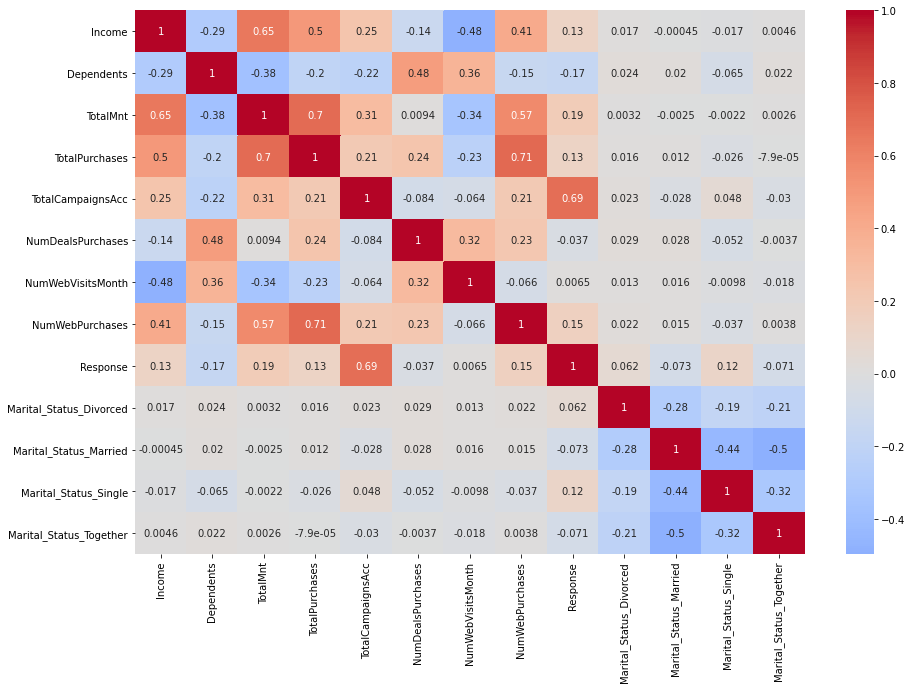

In [49]:
corrs = status_mrkt.corr(method = 'kendall')

plt.figure(figsize=(15,10))  #figure size
sns.heatmap(corrs, cmap='coolwarm', center=0, annot = True);

---

>##### Observation?? 
>
> There isn't any correlation between martial staus and spendings
>
>##### Observations should focus on what there IS, not what there isn't
>
>Let's try to look at the response to campain

---



Is there a connection between the status, dependents and response?

We can groupby, and then unstack:

In [50]:
mrkt_df.groupby(['Marital_Status', 'Dependents'])['Response' ].aggregate('mean').unstack()

Dependents,0,1,2,3
Marital_Status,,,,
Absurd,0.500000,NaN,NaN,NaN
Alone,NaN,0.000000,0.500000,NaN
Divorced,0.448276,0.109244,0.183673,0.000000
Married,0.182609,0.091314,0.089286,0.000000
Single,0.389222,0.130045,0.150685,0.062500
Together,0.163399,0.086957,0.071429,0.066667
Widow,0.370370,0.181818,0.176471,NaN
YOLO,NaN,0.500000,NaN,NaN


Or we can use a pivot table to obtain the same results:

In [51]:
mrkt_df.pivot_table('Response', index='Marital_Status', columns='Dependents', aggfunc='mean')  #aggfunc = 'mean' is the default

Dependents,0,1,2,3
Marital_Status,,,,
Absurd,0.500000,NaN,NaN,NaN
Alone,NaN,0.000000,0.500000,NaN
Divorced,0.448276,0.109244,0.183673,0.000000
Married,0.182609,0.091314,0.089286,0.000000
Single,0.389222,0.130045,0.150685,0.062500
Together,0.163399,0.086957,0.071429,0.066667
Widow,0.370370,0.181818,0.176471,NaN
YOLO,NaN,0.500000,NaN,NaN


Single & Divorced with no kids are more likly to respond to a campaign

---

>##### Observation 5 
>
> Single & Divorced with no kids are more likly to respond to a campaign
>
 

---

Is this it? No!! There is always more to do. We haven't touched country, education, or campaign responses and much more. 


---
> A summary of new functions:
>
>* `drop()` - remove labels or columns [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html?highlight=drop#pandas.DataFrame.drop)
>
>* `str.replace('x','y')` - replace string x with string y
>
>* `reset_index(drop=true)` - resets the index. As defult, the old index is added as a column. Use drop=True to avoid this. [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)
>
>* `plt.subplots_adjust` - a matplotlib function. adjusts space between the plots. [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html)
>
>* `sum(axis=1)` - sums the values according to the rows, instead of the default sum by columns
>
>* create a list using [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) - "do something for data in dataframe if condition holds"
>
>* `countplot()` - counts observations for each category
>
>* `pd.get_dummies()` - creates one-hot encodings for categorical variables [documentation](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)
>
>* `unstack()` - change the hiearachy of data [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html)
>
>* `pivot()` - create a pivot table to group and summarize data [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html)
---